In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#combined_data = pd.read_csv('../input/cleaned-data/cleaned_data.csv')

from datetime import datetime

def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
                          
org_col_names=["No", "year","month", "day", "hour", "pm2.5", "DEWP","TEMP", "PRES", "cbwd", "Iws", "Is", "Ir"]
#col_names = ['pollution', 'dew', 'temp', 'pressure', 'w_dir', 'w_speed', 'snow', 'rain']   
col_names = ['pollution', 'dew', 'temp', 'pressure', 'w_speed', 'snow', 'rain'] 
                            
dataset = pd.read_csv('../input/airpollution-lr/AirPollution.csv',index_col=0, date_parser=parse,parse_dates=[['year', 'month', 'day', 'hour']])     
#https://github.com/jyoti0225/Air-Pollution-Forecasting/blob/master/AirPollutionMultivariate.ipynb
dataset.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [3]:
# Data cleaning
dataset.drop('No', axis=1, inplace=True)
dataset.drop('cbwd', axis=1, inplace=True)
#dataset.drop('year_month_day_hour', axis=0, inplace=True)
dataset.columns = col_names
dataset['pollution'].fillna(0, inplace=True)

dataset = dataset[24:] # drop the first day
dataset.head()
combined_data=dataset
#đổi cột
combined_data = combined_data.reindex([ 'dew', 'temp', 'pressure', 'w_speed', 'snow', 'rain','pollution'], axis=1)
 
#dataset.to_csv('pollution.csv') # save new CSV

In [4]:
combined_data.head()


,dew,temp,pressure,w_speed,snow,rain,pollution
year_month_day_hour,,,,,,,
2010-01-02 00:00:00,-16,-4.0,1020.0,1.79,0,0,129.0
2010-01-02 01:00:00,-15,-4.0,1020.0,2.68,0,0,148.0
2010-01-02 02:00:00,-11,-5.0,1021.0,3.57,0,0,159.0
2010-01-02 03:00:00,-7,-5.0,1022.0,5.36,1,0,181.0
2010-01-02 04:00:00,-7,-5.0,1022.0,6.25,2,0,138.0


In [5]:
X = combined_data.iloc[:, :-1]
y = combined_data.iloc[:, -1]


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [7]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)


LinearRegression()

In [8]:
f'Coefficient of determination R^2 on train set {lin_reg.score(X_train, y_train)}'

'Coefficient of determination R^2 on train set 0.21360417694853562'

In [9]:
f'Coefficient of determination R^2 on test set {lin_reg.score(X_test, y_test)}'

'Coefficient of determination R^2 on test set 0.21592709613790373'

In [10]:
lin_reg.coef_

array([ 4.02452229, -5.85793505, -1.61620795, -0.24705223, -1.84414716,
       -6.82703051])

In [11]:
lin_reg.intercept_

1809.9655888852014

In [12]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(lin_reg, X, y, cv = 3)

In [13]:
score.mean()

0.18754055184544005

In [14]:
pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coeff'])

,Coeff
dew,4.024522
temp,-5.857935
pressure,-1.616208
w_speed,-0.247052
snow,-1.844147
rain,-6.827031


In [15]:
c = 0
for val in lin_reg.coef_:
    effect = 'increase' if val>0 else 'decrease'
    print(f'Holding all other features fixed a 1 unit increase in {X.columns[c]} is associated with {effect} of val in AQI PM2.5')
    c = c+1

Holding all other features fixed a 1 unit increase in dew is associated with increase of val in AQI PM2.5
Holding all other features fixed a 1 unit increase in temp is associated with decrease of val in AQI PM2.5
Holding all other features fixed a 1 unit increase in pressure is associated with decrease of val in AQI PM2.5
Holding all other features fixed a 1 unit increase in w_speed is associated with decrease of val in AQI PM2.5
Holding all other features fixed a 1 unit increase in snow is associated with decrease of val in AQI PM2.5
Holding all other features fixed a 1 unit increase in rain is associated with decrease of val in AQI PM2.5


In [16]:
pred = lin_reg.predict(X_test)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pollution', ylabel='Density'>

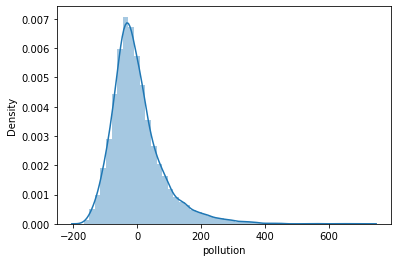

In [17]:
sns.distplot(y_test - pred)
#y_train

In [18]:
from sklearn import metrics
print(f"Mean Abs Error: {metrics.mean_absolute_error(y_test, pred)}")
print(f"Mean Sq Error: {metrics.mean_squared_error(y_test, pred)}")
print(f"Root Mean Error: {np.sqrt(metrics.mean_squared_error(y_test, pred))}")

Mean Abs Error: 59.24228276061772
Mean Sq Error: 6627.619661112832
Root Mean Error: 81.41019384028533


In [19]:
#import pickle
#pickle.dump(lin_reg, open('linreg.pkl', 'wb'))
pred

array([135.24997982,  84.93196993, 135.66654685, ...,  74.94025387,
        57.60515811,  88.96451226])

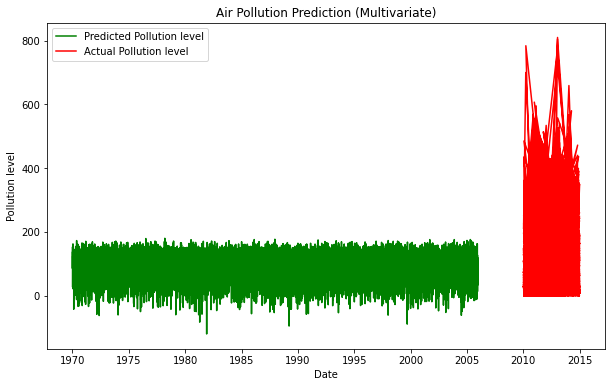

<Figure size 432x288 with 0 Axes>

In [20]:
plt.figure(figsize=(10,6))  
plt.plot(pred, color= 'green',label = 'Predicted Pollution level')
plt.plot(y_test , color = 'red',label = 'Actual Pollution level')

plt.title("Air Pollution Prediction (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.legend()
plt.show()
plt.savefig('graph.png')